<a href="https://colab.research.google.com/github/knana6/PIRO/blob/main/piro_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EC%A0%84%EC%B2%98%EB%A6%AC_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 패키지 설치


In [3]:
!pip -q install easyocr opencv-python-headless matplotlib

# 이미지 업로드

In [4]:
from google.colab import files
uploaded = files.upload()
# 업로드할 파일: lenna256.png, lennaG256.jpg, morph_j.png, puzzle_scan.png

Saving lenna256.png to lenna256 (1).png
Saving lennaG256.jpg to lennaG256 (1).jpg
Saving morph_j.png to morph_j (1).png
Saving puzzle_scan.png to puzzle_scan.png


# 이미지 로드

이미지 로드 완료


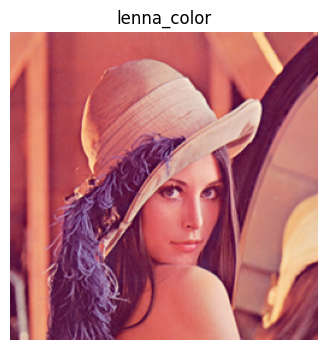

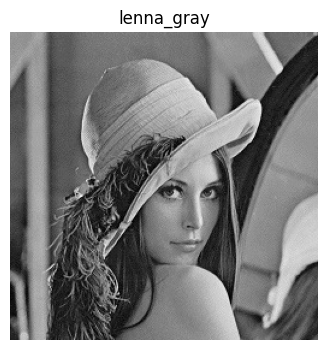

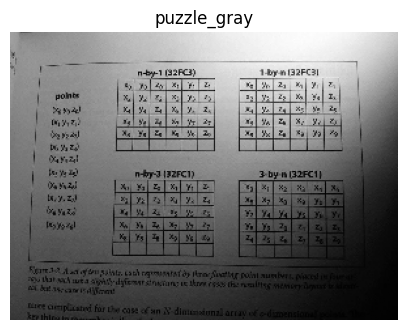

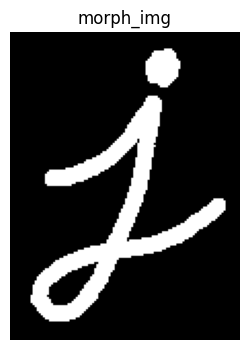

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 로드 함수 (BGR)
def imread_bgr(path):
    # OpenCV는 기본적으로 BGR 순서로 이미지를 읽음
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    # 파일 경로가 잘못되었거나 이미지가 없을 경우 None 반환
    if img is None:
        raise FileNotFoundError(f"이미지 못 찾음: {path}")
    return img

# 이미지 로드 함수 (그레이스케일)
def imread_gray(path):
    # 이미지를 흑백(0~255 밝기값)으로 읽음
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"이미지 못 찾음: {path}")
    return img

# 이미지 시각화 함수p
def show(title, img, cmap=None, figsize=(5,4)):
    plt.figure(figsize=figsize)
    # 2차원 배열이면 그레이스케일 이미지
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or "gray")
    # 3차원 배열이면 컬러 이미지
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

# 파일 로드
lenna_color = imread_bgr("lenna256.png")        # 컬러 레나 (색상 정보가 있는 원본 이미지 예시)
lenna_gray  = imread_gray("lennaG256.jpg")      # 그레이 레나(색상 정보 제거하고 밝기 정보만 있는 이미지)
morph_img   = imread_gray("morph_j.png")        # 모폴로지 연산 실습용 이진 이미지, 배경과 객체가 명확한 이미지
puzzle_bgr  = imread_bgr("puzzle_scan.png")     # 퍼즐 스캔(문서형)

# 컬러 문서 이미지를 그레이스케일로 변환
puzzle_gray = cv2.cvtColor(puzzle_bgr, cv2.COLOR_BGR2GRAY)

print("이미지 로드 완료")
show("lenna_color", lenna_color)
show("lenna_gray", lenna_gray)
show("puzzle_gray", puzzle_gray)
show("morph_img", morph_img)

# 5가지 전처리 함수



## 1. Grayscale (그레이 스케일)

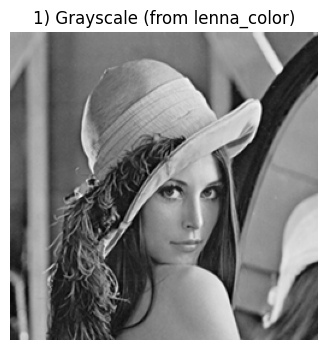

In [10]:
gray_from_color = cv2.cvtColor(lenna_color, cv2.COLOR_BGR2GRAY)
show("1) Grayscale (from lenna_color)", gray_from_color)
# 컬러(BGR) 이미지 → 그레이스케일 이미지로 변환
# OpenCV는 기본 색상 순서가 BGR이므로 COLOR_BGR2GRAY 사용
# 그레이스케일 결과 시각화
# 색상 정보는 제거되고, 각 픽셀은 밝기값(0~255)만 가짐

# 2. Binarization (이진화)

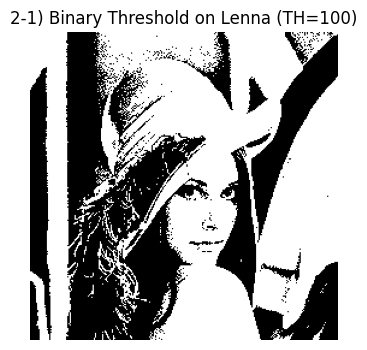

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


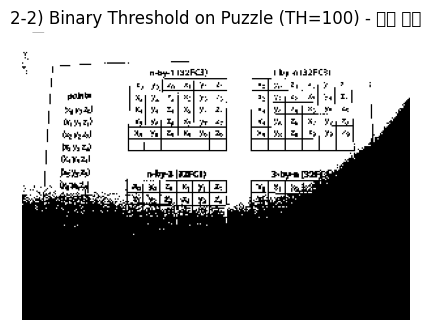

In [11]:
# 하나의 임계값(threshold)을 이미지 전체에 동일하게 적용
# TH 값보다 밝으면 흰색(255), 어두우면 검은색(0)으로 변환
# 임계값을 조절해서 결과 변화를 살펴보자!
TH = 100

# Lenna 이미지에 이진화 적용
# 조명이 비교적 균일한 이미지
_, bin_lenna = cv2.threshold(lenna_gray, TH, 255, cv2.THRESH_BINARY)
show(f"2-1) Binary Threshold on Lenna (TH={TH})", bin_lenna)


# Puzzle(문서 스캔) 이미지에 동일한 임계값 적용
# 조명, 그림자, 배경 밝기가 고르지 않음
_, bin_puzzle = cv2.threshold(puzzle_gray, TH, 255, cv2.THRESH_BINARY)
show(f"2-2) Binary Threshold on Puzzle (TH={TH}) - 한계 확인", bin_puzzle)

# 3. Adaptive Threshold (적응형 이진화)

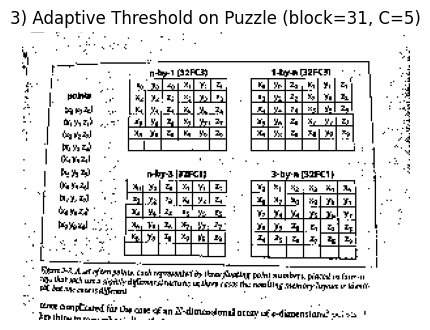

In [12]:
adaptive = cv2.adaptiveThreshold(
    puzzle_gray, # 입력 이미지는 반드시 그레이스케일
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    31, # 주변 영역 크기 (반드시 홀수)
    5 # C : 계산된 임계값에서 빼는 함수
)
show("3) Adaptive Threshold on Puzzle (block=31, C=5)", adaptive)

# 4. Gaussian Blur

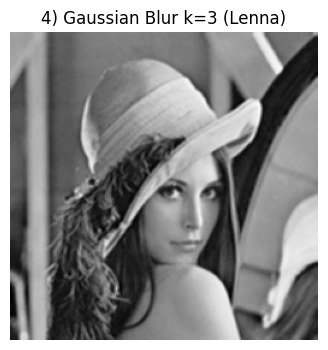

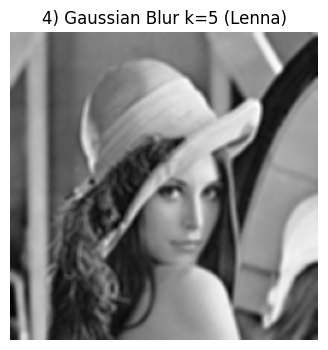

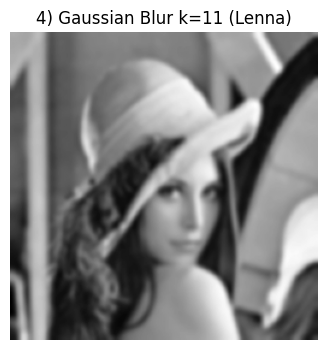

In [13]:
# 가우시안 블러 커널 크기 비교 실험
# 동일한 시그마 값을 사용하고 커널 크기만 바꿔가면서 블러 강도를 확인해보자!
blur_3 = cv2.GaussianBlur(lenna_gray, (3,3), 2.0)
blur_5 = cv2.GaussianBlur(lenna_gray, (5,5), 2.0)
blur_11 = cv2.GaussianBlur(lenna_gray, (11,11), 2.0)

show("4) Gaussian Blur k=3 (Lenna)", blur_3)
show("4) Gaussian Blur k=5 (Lenna)", blur_5)
show("4) Gaussian Blur k=11 (Lenna)", blur_11)

# 5. Morphology

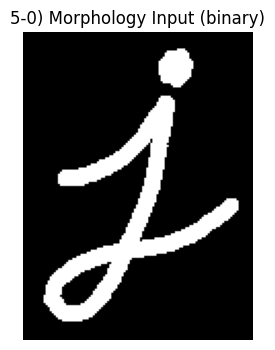

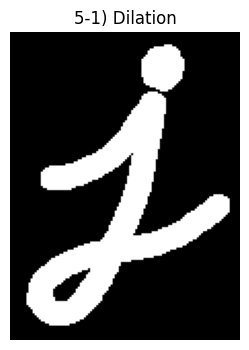

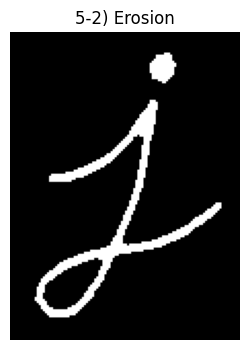

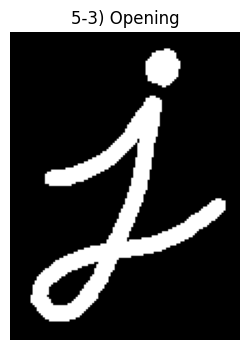

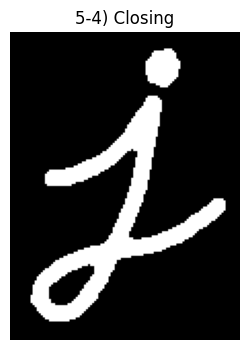

In [15]:
_, morph_bin = cv2.threshold(morph_img, 127, 255, cv2.THRESH_BINARY)

# 구조 요소 생성
# 모폴로지 연산에서 어떤 이웃을 볼 것인가를 정의
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
# 팽창
dil = cv2.dilate(morph_bin, kernel, iterations=1)
# 침식
ero = cv2.erode(morph_bin, kernel, iterations=1)
# 열림
opn = cv2.morphologyEx(morph_bin, cv2.MORPH_OPEN, kernel, iterations=1)
# 닫힘
cls = cv2.morphologyEx(morph_bin, cv2.MORPH_CLOSE, kernel, iterations=1)
# iteration은 반복 횟수로 늘릴수록 효과가 강해짐

show("5-0) Morphology Input (binary)", morph_bin)
show("5-1) Dilation", dil)
show("5-2) Erosion", ero)
show("5-3) Opening", opn)
show("5-4) Closing", cls)